[Reference](https://towardsdatascience.com/shared-nearest-neighbors-a-more-robust-distance-metric-064d7f99ffb7)

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import statistics

from sklearn import datasets

class KNN:
    def __init__(self, metric='euclidian'):
        self.metric = metric

    def fit_predict(self, data, k):
        data = pd.DataFrame(data)
        balltree = BallTree(data, metric=self.metric)

        # Get the distances to the k nearest neighbors for each record
        knn = balltree.query(data, k=k)[0]

        # Get the mean distance to the k nearest neighbors for each record
        scores = [statistics.mean(x[:k]) for x in knn]
        return scores

In [6]:
class SNN:
    def __init__(self, metric='euclidian'):
        self.metric = metric

    def get_pairwise_distances(self, data, k):
        data = pd.DataFrame(data)
        balltree = BallTree(data, metric=self.metric)
        knn = balltree.query(data, k=k+1)[1]
        pairwise_distances = np.zeros((len(data), len(data)))
        for i in range(len(data)):
            for j in range(i+1, len(data)):
                if (j in knn[i]) and (i in knn[j]):
                    weight = len(set(knn[i]).intersection(set(knn[j])))
                    pairwise_distances[i][j] = weight
                    pairwise_distances[j][i] = weight
        return pairwise_distances

    def fit_predict(self, data, k):
        data = pd.DataFrame(data)
        pairwise_distances = self.get_pairwise_distances(data, k)
        scores = [statistics.mean(sorted(x, reverse=True)[:k]) for x in pairwise_distances]
        min_score = min(scores)
        max_score = max(scores)
        scores = [min_score + (max_score - x) for x in scores]
        return scores

In [11]:
def test_variable_blobs(nrows=1000, ncols=500, nclusters=60, outlier_multiplier=2.0, k=30, metric='manhattan'):
    np.random.seed(1)

    # ########################################################
    # Create the test data

    # Set the size of each cluster
    n_samples_arr = []
    remaining_count = nrows
    for i in range(nclusters-1):
        cluster_size = np.random.randint(1, remaining_count // (nclusters - i))
        n_samples_arr.append(cluster_size)
        remaining_count -= cluster_size
    n_samples_arr.append(remaining_count)

    # Set the density of each cluster
    cluster_std_arr = []
    for i in range(nclusters):
        cluster_std_arr.append(np.random.uniform(low=0.1, high=2.0))

    # Set the center location of each cluster
    cluster_centers_arr = []
    for i in range(nclusters):
        cluster_centers_arr.append(np.random.uniform(low=0.0, high=10.0, size=ncols))

    # Create the sample data using the specified cluster sizes, densities, and locations
    x, y = datasets.make_blobs(n_samples=n_samples_arr,
                      cluster_std=cluster_std_arr,
                      centers=cluster_centers_arr,
                      n_features=ncols,
                      random_state=0)
    df = pd.DataFrame(x)

    # Add a single known outlier to the data
    avg_row = [x[:, i].mean() for i in range(ncols)]
    outlier_row = avg_row.copy()
    outlier_row[0] = x[:, 0].max() * outlier_multiplier
    df = pd.concat([df, pd.DataFrame([outlier_row])])
    df = df.reset_index(drop=True)

    # ########################################################
    # Compare standard distance metrics to SNN

    # Calculate the outlier scores using standard KNN
    scored_df = df.copy()
    knn = KNN(metric=metric)
    scored_df['knn_scores'] = knn.fit_predict(df, k=k)

    # Calculate the outlier scores using SNN
    snn = SNN(metric=metric)
    scored_df['snn_scores'] = snn.fit_predict(df, k=k)

    # Plot the distribution of scores for both detectors and show
    # the score for the known outlier (in context of the range of
    # scores assigned to the full dataset)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    sns.histplot(scored_df['knn_scores'], ax=ax[0])
    ax[0].axvline(scored_df.loc[nrows, 'knn_scores'], color='red')
    sns.histplot(scored_df['snn_scores'], ax=ax[1])
    ax[1].axvline(scored_df.loc[nrows, 'snn_scores'], color='red')
    plt.suptitle(f"Number of columns: {ncols}")
    plt.tight_layout()
    plt.show()

    return df

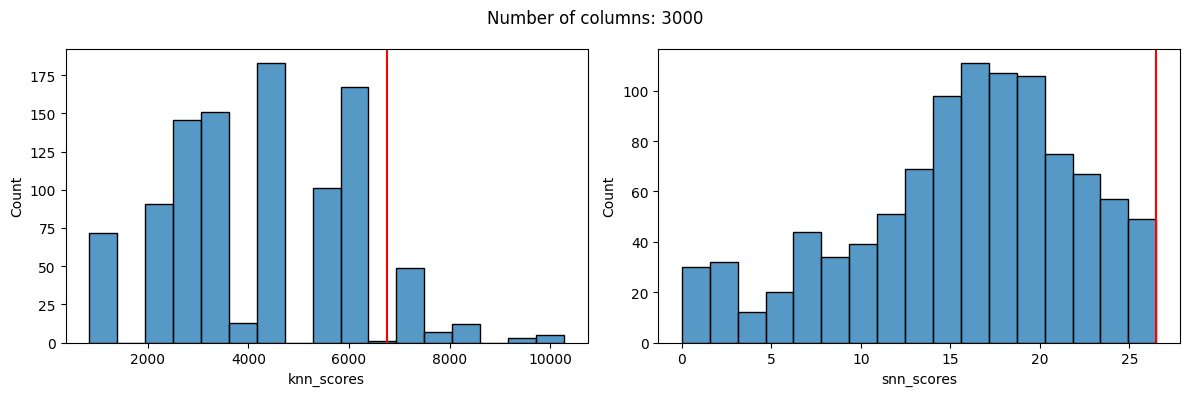

In [12]:
df = test_variable_blobs(nrows=1000, ncols=3000, nclusters=20, k=30)

In [13]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=20, min_samples=2).fit(df.values)
print(clustering.labels_)
print(pd.Series(clustering.labels_).value_counts())

[ 0 -1 -1 ... -1 -1 -1]
-1    928
 0     66
 1      7
Name: count, dtype: int64


In [14]:
snn = SNN(metric='manhattan')
pairwise_dists = snn.get_pairwise_distances(df, k=100)
print(pairwise_dists)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
d = pd.DataFrame(pairwise_dists).apply(lambda x: 1000-x)
clustering = DBSCAN(eps=975, min_samples=2, metric='precomputed').fit(d.values)
print(clustering.labels_)
display(pd.Series(clustering.labels_).value_counts())

[ 0  1  2 ...  4  3 -1]


,count
5,182
3,145
2,143
6,140
9,102
1,77
0,72
10,51
7,38
8,17
